<img src="https://github.com/djp840/MSDS_422_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS422 Assignment 09


<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages 



In [1]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.3.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Environment

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')

<img src="https://github.com/djp840/MSDS_422_Public/blob/master/images/Encoder_Decoder.png?raw=1">

### Variational autoencoder (VAE)

#### Encoder Network
mapping inputs to our latent distribution parameters

In [7]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

Sample new similar points from the latent space

In [8]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Map these sampled latent points back to reconstructed inputs

In [9]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [10]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 50500     
_________________________________________________________________
decoder (Functional)         (None, 784)               51152     
Total params: 101,652
Trainable params: 101,652
Non-trainable params: 0
_________________________________________________________________


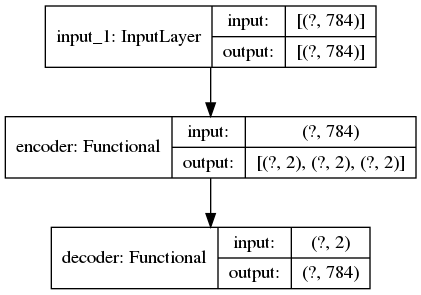

In [11]:
keras.utils.plot_model(vae, "EncoderModel.png", show_shapes=True) 

What we've done so far allows us to instantiate 3 models:

    an end-to-end autoencoder mapping inputs to reconstructions
    an encoder mapping inputs to the latent space
    a generator that can take points on the latent space and will output the corresponding reconstructed samples


### Train the model <br>
Using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term

In [12]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

#### Train our VAE on MNIST digits

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [14]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [15]:
history = vae.fit(x_train, x_train,
            epochs=100,
            batch_size=32,
            validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 7s 4ms/step - loss: 187.0781 - val_loss: 168.5986
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 166.4089 - val_loss: 163.9111
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 162.4194 - val_loss: 161.0750
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 160.1231 - val_loss: 159.4142
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 158.5718 - val_loss: 158.1172
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 157.3298 - val_loss: 156.9640
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 156.2554 - val_loss: 156.5051
Epoch 8/100
1875/1875 [==============================] - 7s 4ms/step - loss: 155.3146 - val_loss: 154.9920
Epoch 9/100
1875/1875 [==============================] - 7s 4ms/step - loss: 154.5252 - val_loss: 154.5942
Epoch 10/100
1875/1875 [=============

Epoch 77/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.9010 - val_loss: 146.7790
Epoch 78/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.8520 - val_loss: 146.9740
Epoch 79/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.8295 - val_loss: 147.0358
Epoch 80/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.7615 - val_loss: 146.9218
Epoch 81/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.7551 - val_loss: 146.8235
Epoch 82/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.7015 - val_loss: 146.6989
Epoch 83/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.6514 - val_loss: 146.7663
Epoch 84/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.6091 - val_loss: 146.5478
Epoch 85/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.5715 - val_loss: 146.8202
Epoch 86/100
1875/1875 [====

### Review classes on the latent 2D plane

In [21]:
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(12, 12))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.title('VAE 64 Latent Space')
    plt.colorbar()
    plt.show()

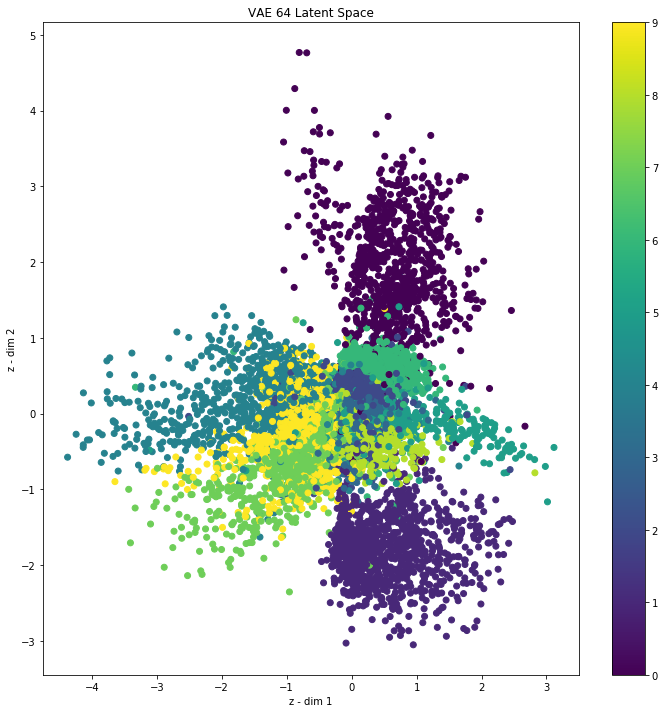

In [22]:
data = (x_test, y_test)
viz_latent_space(encoder, data)

### VAE is a generative model generate new digits

Visualization of the latent manifold that "generates" the MNIST digits

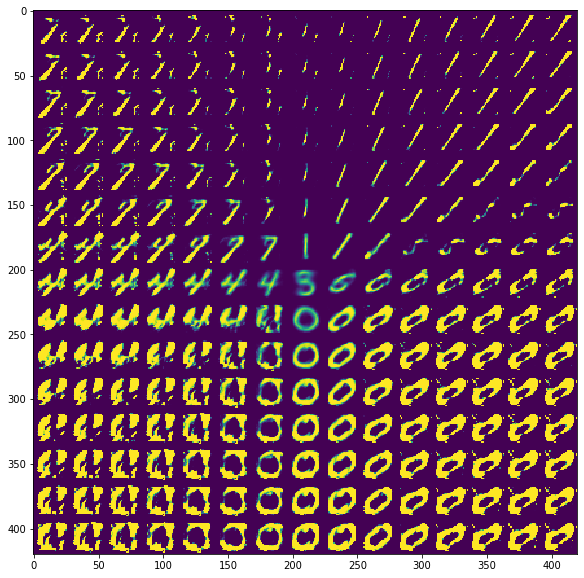

In [16]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()